In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [79]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Connecting the image with HSC photometric measurements

In [308]:
coord_1 = SkyCoord(138.808426, 3.703354, frame='icrs', unit='deg')
#coord_1 = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')

# Physical size
s_phy = 100.0 * u.kpc
redshift = 0.15
#redshift = 0.30

### Get the i-band cutout image 

In [309]:
cutout = task.hsc_cutout(
    coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
    archive=pdr2, use_saved=False, output_dir=output_dir, verbose=True, 
    save_output=False)

# Retrieving cutout image in filter: i


### Get the i-band PSF image

In [310]:
psf_i = task.hsc_psf(coord_1, filters='i', archive=pdr2, save_output=False)[0].data

# Retrieving coadd PSF model in filter: i


### Search for HSC objects in the cutout

* Options:
    - `psf = True`: get forced PSF photometry
    - `cmodel = True`: get forced CModel photometry
    - `aper = True`: get the PSF-matched aperture photometry
    - `shape = True`: get the forced SDSS shapes
    - `meas = [grizy]`: get the independent photometric measurements in a specific band
    - `flux = False`: get the flux instead of AB magnitude

In [311]:
# Increase the box size a little to include objects just at the edge of the cutout
s_box = s_phy * 1.05

cutout_objs = task.hsc_box_search(
    coord_1, box_size=s_box, redshift=redshift, archive=pdr2,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

# WCS of the image
cutout_wcs = wcs.WCS(cutout[1].header)

Waiting for query to finish... [Done]
# 155/188 objects are clean.


### Visualize the detection and the shape of the objects

* Can highlight the "bad" objects using `show_bad = True` (**black circle**)
* Can only show the clean objects using `show_clean = True` 
* Point sources are shown as **Light blue cross**:
    - Not all these "point sources" are actually stars. 
    - You can also show the "SDSS shape" for point sources using `show_sdssshape=True`
* Extended objects are shown using **brown ellipse**.
    - Can show one ellipse using a `fracDev`-weighted shape. 
    - Can show two ellipses per object: one for `cmodel.exp`, one for `cmodel.dev`.
* You can also color-coded the ellipses for galaxies using their CModel magnitude in one band
    - Set `show_mag = True`, and provides a filter name using `band = 'i'`.
    
#### `SDSSShape` for stars and weighted shape for galaxies

112 188
# 94/112 objects are clean.
# There are 26 point sources on the cutout
# There are 86 extended sources on the cutout


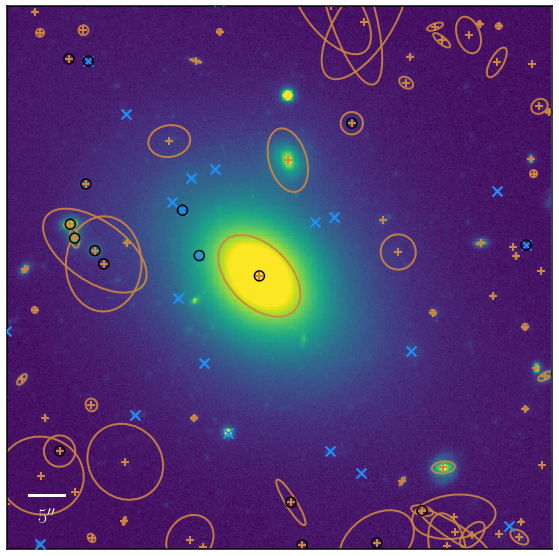

In [326]:
flux_mask = ((cutout_objs['i_psf_mag'] <= 26.5) | (cutout_objs['i_cmodel_mag'] <= 26.5))
clean_mask = catalog.select_clean_objects(cutout_objs, check_flag=None)

objs_use = cutout_objs[clean_mask & flux_mask]

print(len(objs_use), len(cutout_objs))

_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10)

#### Only label point sources, show the ellipses of both `Exp` and `DeV` components in `CModel` 

# 94/112 objects are clean.
# There are 26 point sources on the cutout
# There are 86 extended sources on the cutout


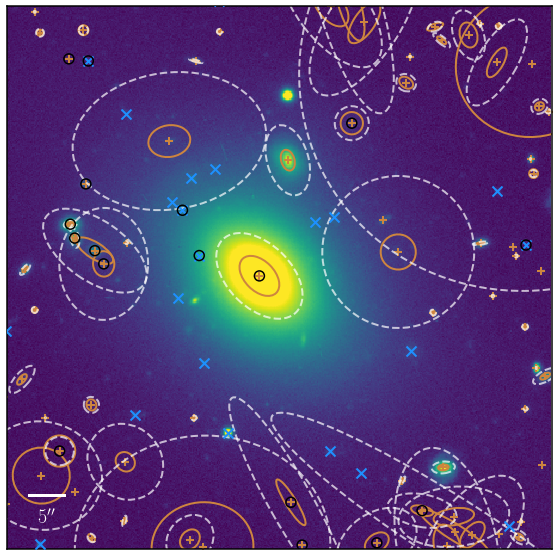

In [327]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10, show_weighted=False)

#### Color-coded the weighted-ellipse for galaxies

# 94/112 objects are clean.
# There are 26 point sources on the cutout
# There are 86 extended sources on the cutout


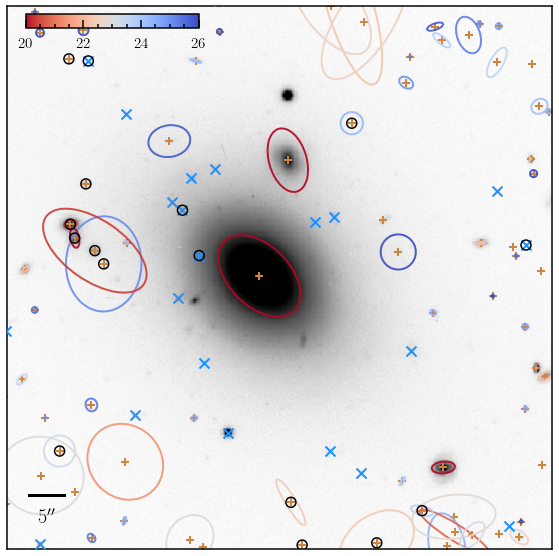

In [328]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, xsize=10, band='i', cmap='Greys', 
    show_mag=True, scale_bar_color='k')

#### Color-coded both ellipese for `Exp` and `DeV` components

# 94/112 objects are clean.
# There are 26 point sources on the cutout
# There are 86 extended sources on the cutout


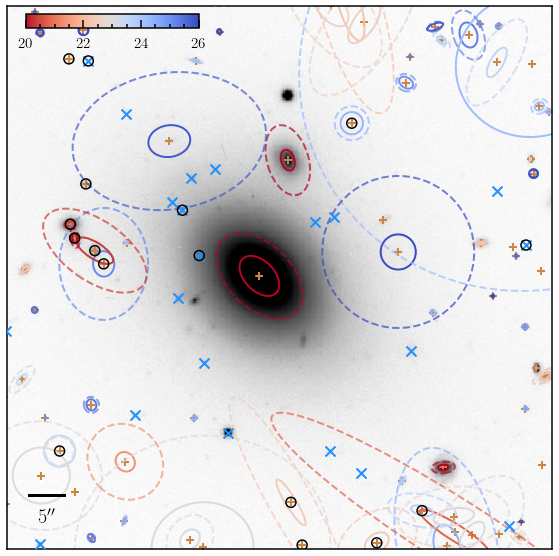

In [329]:
_ = plotting.cutout_show_objects(
    cutout, objs_use, show_clean=False, xsize=10, band='i', cmap='Greys', 
    show_mag=True, show_weighted=False, scale_bar_color='k')

In [357]:
gal_index = np.argmin(objs_use['i_cmodel_mag'])
gal_cen = objs_use[gal_index]

x_gal, y_gal = catalog.world_to_image(objs_use, cutout_wcs, update=False)
print(x_gal[gal_index], y_gal[gal_index])

r_exp, ba_exp, pa_exp = catalog.moments_to_shape(
    gal_cen, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_dev, ba_dev, pa_dev = catalog.moments_to_shape(
    gal_cen, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=False)
print(r_exp, ba_exp, pa_exp)
print(r_dev, ba_dev, pa_dev)

flux_exp = catalog.abmag_to_image(gal_cen['cmodel_exp_mag'])
flux_dev = catalog.abmag_to_image(gal_cen['cmodel_dev_mag'])
print(flux_exp, flux_dev)

211.55655357006253 228.92210428337808
20.071627128691897 0.6257910357208731 -45.418261593275886
43.36921941666376 0.618054586533942 -44.63023317623998
58684.91214326437 105695.6239451028


In [330]:
import galsim

In [354]:
comp_exp = galsim.Exponential(half_light_radius=r_exp, flux=flux_exp)
shape_exp = galsim.Shear(q=ba_exp, beta=pa_exp * galsim.degrees)
comp_exp = comp_exp.shear(shape_exp)

comp_dev = galsim.DeVaucouleurs(half_light_radius=r_dev, flux=flux_dev)
shape_dev = galsim.Shear(q=ba_dev, beta=pa_dev * galsim.degrees)
comp_dev = comp_dev.shear(shape_dev)

gal_cmodel = galsim.Add([comp_exp, comp_dev])

psf_obj = galsim.InterpolatedImage(galsim.image.Image(psf_i), scale=1.0, normalization='flux')

gal_conv = galsim.Convolve([gal_cmodel, psf_obj])

gal_img = galsim.Image(cutout[1].shape[1], cutout[1].shape[0], scale=1.0)

gal_img = gal_conv.drawImage(gal_img)

In [352]:
cutout[1].data.max()

234.08675

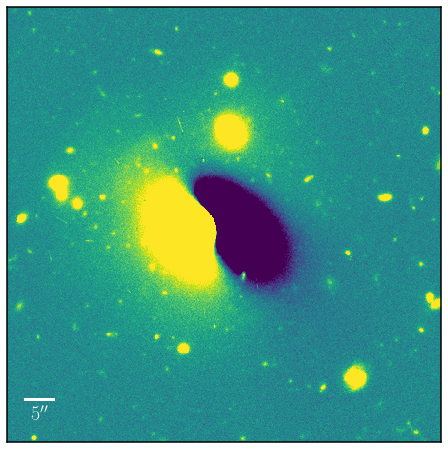

In [353]:
_ = plotting.display_single(cutout[1].data - gal_img.array)

In [306]:
x_clean, y_clean = catalog.world_to_image(cutout_clean, cutout_wcs, update=False)
x_dirty, y_dirty = catalog.world_to_image(cutout_objs[~clean_mask], cutout_wcs, update=False)

# Get the stars and show the SDSS shape
star_mask = cutout_clean['i_extendedness'] < 0.5
cutout_star = cutout_clean[star_mask]
x_star, y_star = x_clean[star_mask], y_clean[star_mask]
r_star, ba_star, pa_star = catalog.moments_to_shape(
    cutout_star, shape_type='i_sdssshape', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_star) > 0:
    print("# There are {} point sources on the cutout".format(len(cutout_star)))
else:
    print("# No point source is found!")

# Get the extended objects
gal_mask = ~star_mask
cutout_gal = cutout_clean[gal_mask]
x_gal, y_gal = x_clean[gal_mask], y_clean[gal_mask]
r_exp, ba_exp, pa_exp = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_dev, ba_dev, pa_dev = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_gal, ba_gal, pa_gal = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_ellipse', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_gal) > 0:
    print("# There are {} extended sources on the cutout".format(len(cutout_gal)))
else:
    print("# No point source is found!")

# There are 16 point sources on the cutout
# There are 99 extended sources on the cutout


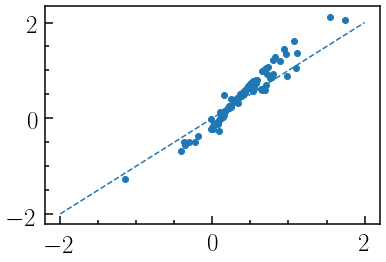

In [324]:
plt.scatter(np.log10(r_exp), np.log10(r_dev))
plt.plot([-2.0, 2.0], [-2.0, 2.0], linestyle='--')